# Regression Problem 

Group13
 
 - Chris Lochhead, 
 - Eryn Rigley, 
 - David Currie, 
 - Jamie Moyes, 
 - Alistair Brash


## Build a model to predict the popularity of a song

Your task for this part of the class assignment is to build a model to predict the popularity of a song. The data is drawn from here:  https://www.kaggle.com/cnic92/spotify-past-decades-songs-50s10s. The only change that has been made is to first column where "Number" has be re-named as "Id". Also note the points that "There are some missing values, and the year is not always coherent due to some re-releases etc." However, not all the data has been used so make sure you download the training data from this (the competition) page.

Your challenge is to build a good machine learning model that is able to predict the popularity of a song. Popularity is an integer value so treat this as a regression problem. Ignoring Id and Popularity (named "pop") there are 13 other attributes in the dataset that you may use to build your model. Use as many or as few of these as you like, but remember to spend time exploring, understanding and cleaning the data. The performance of the model will be determined by the RMSE.

In [1]:
#import modules
#Basics for math, dataframes, plotting etc...
import pandas as pd
import seaborn as sns; sns.set()
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

#SKlearn for machine learning algorithms and machine learning accessories, metrics etc...
from sklearn import preprocessing
from sklearn.preprocessing import scale, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [2]:
#Import data
data = pd.read_csv("file:///Users//erynrigley///Desktop//CS98XRegressionTrain.csv")
test_data = pd.read_csv("file:///Users//erynrigley///Desktop//CS98XRegressionTest.csv")

### Initial Split and Tidying of Data

We firstly need to remove NaN values from the training data. This is because a large number of NaN values will act as noise, and likely  reduce the accuracy of a model.
For the test data, we are not to get rid of any rows, so we will fill in any missing data with a simple placeholder char.

In [3]:
data.isnull().sum()

Id            0
title         0
artist        0
top genre    15
year          0
bpm           0
nrgy          0
dnce          0
dB            0
live          0
val           0
dur           0
acous         0
spch          0
pop           0
dtype: int64

In [4]:
#Just drop NA values for the testing data, since we cannot get rid of any rows in the test set, just replace the empty value
#with a string so it will still work with a model.
data = data.dropna()
test_data = test_data.fillna("NaN")

#Remove the ID columns: save the test ID's for later when exporting prediction files that require these ID's in the submission format
data = data.drop(columns = 'Id')
test_Ids = test_data['Id']
test_data = test_data.drop(columns = 'Id')


In [5]:
data.head()

,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,My Happiness,Connie Francis,adult standards,1996,107,31,45,-8,13,28,150,75,3,44
2,How Deep Is Your Love,Bee Gees,adult standards,1979,105,36,63,-9,13,67,245,11,3,77
3,Woman in Love,Barbra Streisand,adult standards,1980,170,28,47,-16,13,33,232,25,3,67
4,Goodbye Yellow Brick Road - Remastered 2014,Elton John,glam rock,1973,121,47,56,-8,15,40,193,45,3,63
5,Grenade,Bruno Mars,pop,2010,110,56,71,-7,12,23,223,15,6,74


### Encoding

In [6]:
data.dtypes

title        object
artist       object
top genre    object
year          int64
bpm           int64
nrgy          int64
dnce          int64
dB            int64
live          int64
val           int64
dur           int64
acous         int64
spch          int64
pop           int64
dtype: object

 The features of the data (from the Kaggle page):
 
 - top genre: genre of the song
 - year: year of the song (due to re-releases, the year might not correspond to the release year of the original song)
 - bpm(beats per minute): beats per minute
 - nrgy(energy): energy of a song, the higher the value the more energetic the song is
 - dnce(danceability): the higher the value, the easier it is to dance to this song.
 - dB(loudness): the higher the value, the louder the song.
 - live(liveness): the higher the value, the more likely the song is a live recording.
 - val(valence): the higher the value, the more positive mood for the song.
 - dur(duration): the duration of the song.
 - acous(acousticness): the higher the value the more acoustic the song is.
 - spch(speechiness): the higher the value the more spoken word the song contains.
 - pop(popularity): the higher the value the more popular the song is.
 
The data has a categorical values included in Title, Artist, Top Genre. These will be encoded into numerical values, so a model can be built around the data. This would be much more difficult with a split between string and integers.

In [7]:
#change string data to numerical
#title and artist will likely be discarded later, but its worth saving that until after an EDA
lencoder = preprocessing.LabelEncoder()

title = data.iloc[:, [0]]
artist = data.iloc[:, [1]]
genre = data.iloc[:, [2]]

data['title'] = lencoder.fit_transform(title)
data['artist'] = lencoder.fit_transform(artist)
data['top genre'] = lencoder.fit_transform(genre)

title = test_data.iloc[:, [0]]
artist = test_data.iloc[:, [1]]
genre = test_data.iloc[:, [2]]

test_data['title'] = lencoder.fit_transform(title)
test_data['artist'] = lencoder.fit_transform(artist)
test_data['top genre'] = lencoder.fit_transform(genre)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Ad an improvement we tried 1-hot-encoding using pandas.get_dummies. Rather than giving each instance a numerical value, this assigns binary values to categories. The hope is that one-hot-encoding will avoid creating false correlations between features and instances which do not actually exist. Rather, a model can aim to find the true structure of the data. 

In [8]:
#data['title'] = pd.get_dummies(title)
#data['artist'] = pd.get_dummies(artist)
#data['top genre'] = pd.get_dummies(genre)

#test_data['title'] = pd.get_dummies(title)
#test_data['artist'] = pd.get_dummies(artist)
#test_data['top genre'] = pd.get_dummies(genre)

In fact, this method did not make a great improvement upon our score, but rather impeded it. Which is why we commented it out.

### Baseline

We will create a basic linear regression model for reference. No changes will be made for this model, other than the fitting and cleaning necessary to work with a machine learning algorithm.

We will also score this model to see how well it performs. Our aim is to beat the baseline through data science and engineering techniques, informed by an EDA.

The score to beat is ~ 9.67

In [9]:
Linear_Model = LinearRegression()

y = data['pop']
X = data.drop(columns = 'pop')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Linear_Model.fit(X_train, y_train)
Linear_Prediction = Linear_Model.predict(X_test)

print("Baseline RMSE for linear regression: ", np.sqrt(mean_squared_error(y_test, Linear_Prediction, 
    sample_weight=None, multioutput='uniform_average')))

Final_Linear_Prediction = Linear_Model.predict(test_data)

Baseline RMSE for linear regression:  9.779192524889833


## Logistic Regression

It is worth getting a baseline for logistic regression also. This provides a significantly worse RMSE value. This is unsurprising as the popularity value is essentially continuous, making a linear regression model better suited than other forms of regression.

In [10]:
Logistic_Model = LogisticRegression()

y = data['pop']
X = data.drop(columns = 'pop')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Logistic_Model.fit(X_train, y_train)
Logistic_Prediction = Logistic_Model.predict(X_test)

print("Baseline RMSE for logistic regression: ", np.sqrt(mean_squared_error(y_test, Logistic_Prediction, 
    sample_weight=None, multioutput='uniform_average')))


Baseline RMSE for logistic regression:  12.410589320122043


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Under-sampling

It can be observed that there is a significant slope in the data, with around 80% of the values being over 50% popular. This will likely bias the model toward assigning higher values than should be expected, So we will create a seperate dataframe which aims to take this 80:20 split and put it closer to 60:40. This way, the data will be more normal in its distribution without sacrificing too many data points.

In [11]:
#Under-sampling model
pop_mean = data['pop'].mean()
print("The mean of the data is: {:.2f}".format(pop_mean))

# Poportion of songs that are very popular, only 19% less than 50% popular, meaning classifier will be biased to higher scores
print("The proportion of songs that are less than 50% popular: {:.2f}".format(data[data['pop'] <= 50 ]['pop'].count() / data.shape[0]))

#Split the data by popularity
unpopular_data = data[data['pop'] <= 50 ]
popular_data = data[data['pop'] > 50 ]

#Get the counts of each to inform our decision of how to recombine them
print("Unpopular: Popular ratio: ", unpopular_data.shape[0], popular_data.shape[0])

#This provides around a 65:35 split, the discrepancy between the data is huge and doing any lower would risk decimating
#the number of data points we have to work with.
reduced_popular_data = popular_data[-127:]
Balanced_data = pd.concat([reduced_popular_data, unpopular_data])

The mean of the data is: 61.56
The proportion of songs that are less than 50% popular: 0.20
Unpopular: Popular ratio:  87 351


### Outlier Removal

We found that outlier removal had an averse effect on our scoring, and so have commented out our methods for outlier removal. We used the z score method, which calculates the z score for our data and builds a fence around the data to remove those instances which have high z scores. Z score calculates the variance, so an instance with high variance (distance from the mean) will be an outlier. 

We tried different fences for the z score but ultimately outlier removal did not help our accuracy scores in the competition. We left in our method for you to see what we trialed through our EDA and model building process. 

In [12]:
#Remove outlying values
#Due to the opinion based nature of the data, there is likely a high level of variance in the results and outliers
#will only serve to hinder a regression model, due to the sheer number of unique values, the title column will also be dropped
#data = data.drop(columns = 'title') 
#test_data = test_data.drop(columns = 'title')

#Transform dataframe into an array for the purpose of this transformation
#data_np = pd.DataFrame.to_numpy(data) 
#z_score = np.abs(stats.zscore(data_np))
#data_np = data_np[(z_score < 3).all(axis=1)]

#Change back to dataframe
#data_clean = pd.DataFrame(data_np)
#data_clean.columns = ['artist', 'topgenre', 'year', 'bpm', 'nrgy', 'dnce', 'dB', 'live',
       #'val', 'dur', 'acous', 'spch', 'pop']
     
#Cant skip outliers for the test obviously    
#test_data_clean = test_data

## Charting the data

The next stage is to understand the categories better as opposed to gleaming information of the data as a whole. Firstly with a chart to examine the number of unique values in the data. High numbers of unique data as observed in the title and artist are likely to confuse a regression model and it may be advisable to remove them prior to training.

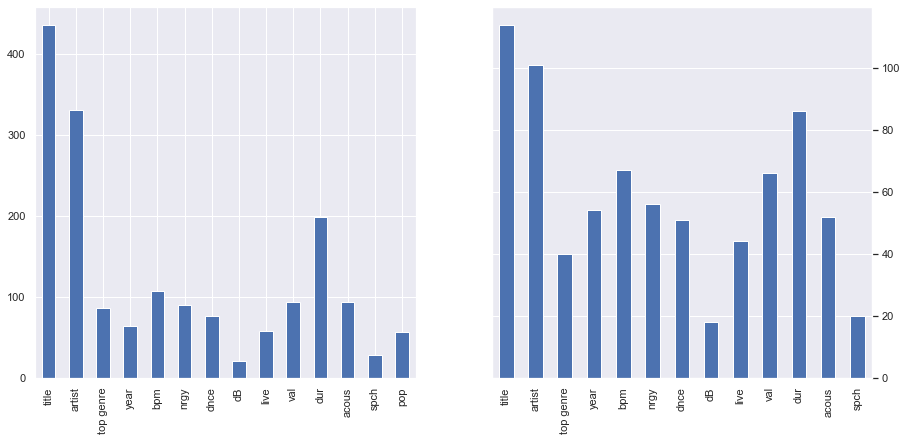

In [13]:
#Re-examine the number of uniques post cleaning to see if anything is unlikely to be helpful in a regression model
plt.subplot(2,2,1)
data.nunique().plot(kind='bar', figsize=(15,15))
plt.subplot(2,2,2)
test_data.nunique().plot(kind='bar', secondary_y = True)

We can also observe the testing and training data are similar in terms of their uniques which will be beneificial for prediction.

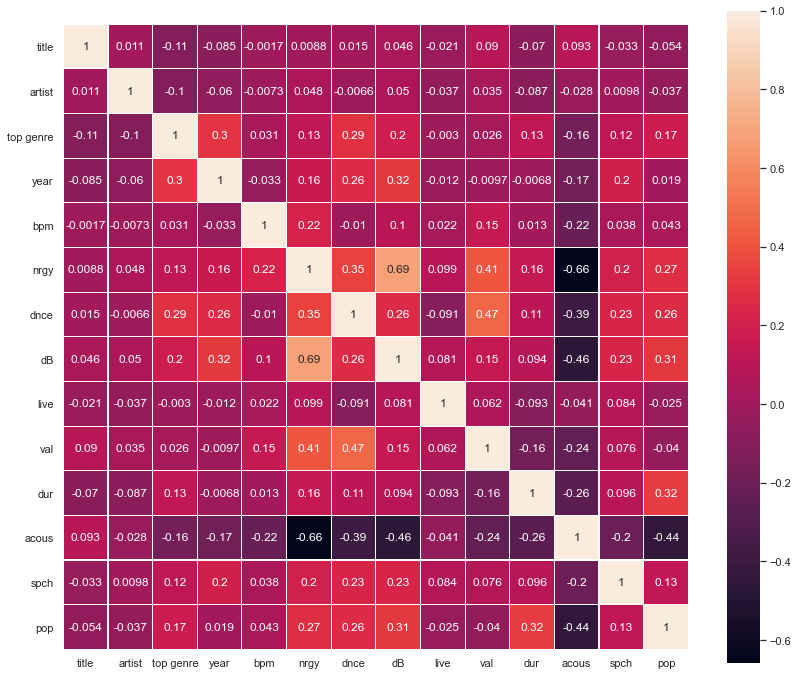

In [14]:
#Now generate a heatmap to view associations between variables : values with low or negative correlation with the target variable
#may be a hinderance to the model
plt.figure(figsize=(14,12))
sns.heatmap(data.astype(float).corr(),linewidths=0.1, 
            square=True,  linecolor='white', annot=True)
plt.show()

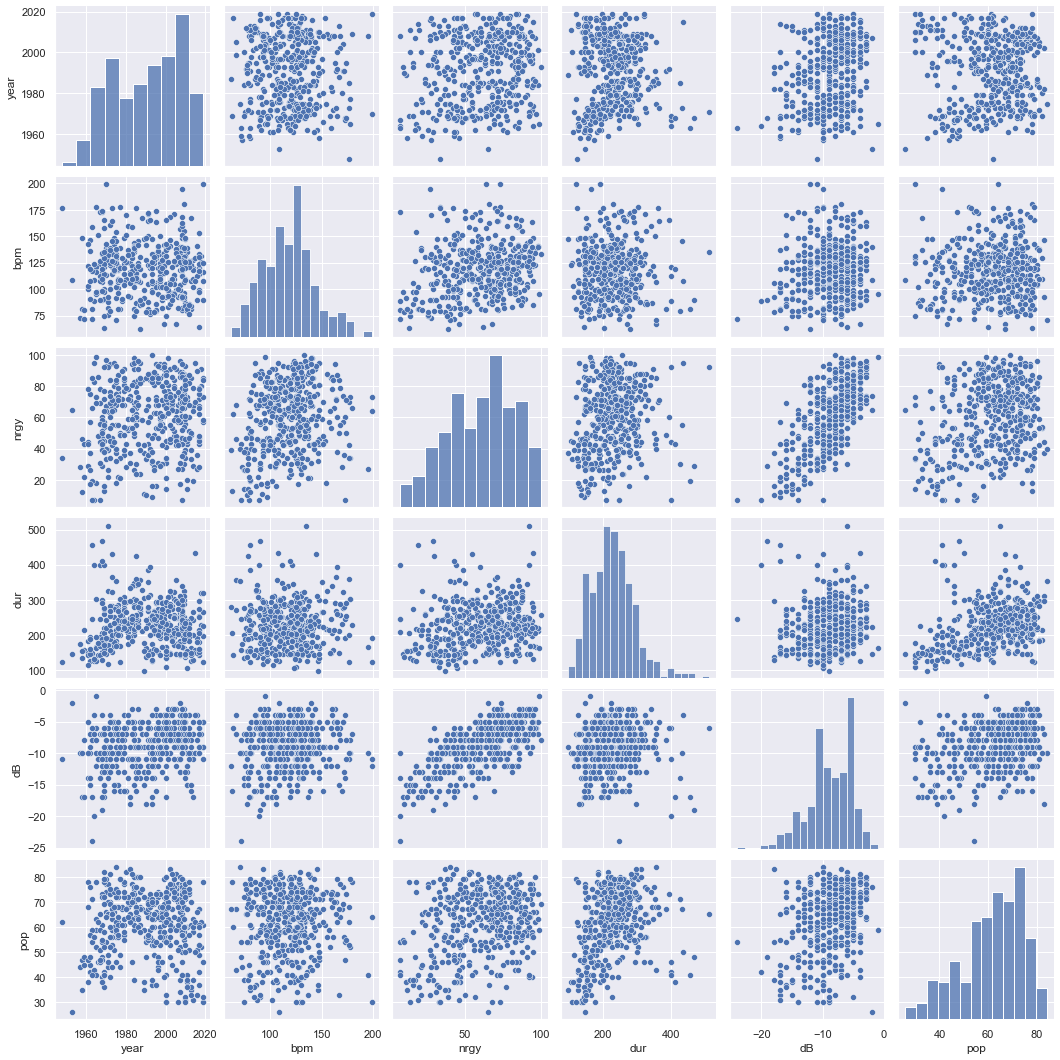

In [15]:
sns.pairplot(data[['year','bpm','nrgy','dur','dB', 'pop']])

A final step in finding the most important features is to calculate the feature importance score. We can do this by building a random forest classifier, and calculating the importance of features to that classifier. We can do that with this dataset because Random forest classifiers are used in regression problems and classification problems.

In [16]:
from sklearn.ensemble import RandomForestClassifier
y = data['pop']
X = data.drop(columns = 'pop')
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size = 0.2, random_state = 42)

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train_,y_train_)
for name, score in zip(data.columns, rnd_clf.feature_importances_):
    print(name, score)

title 0.08888076477450636
artist 0.08372588598526379
top genre 0.06254661882889687
year 0.07973702216412641
bpm 0.08046332303159703
nrgy 0.08316670727701489
dnce 0.08026060624425675
dB 0.0646428327793299
live 0.07869287374630267
val 0.0804083606985404
dur 0.0876464026048556
acous 0.08041770384880642
spch 0.049410898016503


### Random Forest Classifier

Tried a random forest classifier as a powerful ensemble method. Trained via bootstrap aggregation (training a model on different subsets of the data and bringing it together), Random Forests should yield a better result than a single decision tree/regression model. But as we can see below, RF did not perform well as an ensemble method for this data...and did not beat our baseline score.

In [17]:
RandForPred = rnd_clf.predict(X_test_)
print(np.sqrt(mean_squared_error(y_test_, RandForPred, sample_weight=None, multioutput='uniform_average')))

Final_rnd_Prediction = rnd_clf.predict(test_data)

12.861146562771568


### Feature Selection

Looking at the graph, the heatmap and feature selection scores, we can see that 'Artist' has a high number of unique values, and also has a low correlation with ay other feature. It also has a low feature importance score. From this we can assume it is unlikely that 'Artist' would be of much value to a linear regression model. 

In addition, we found that 'acous' also has a low correlation value with any other feature. Especially with those features which *do* have a high correlation to others, such as 'nrgy', 'dnce' and 'dB'. For this reason we also deleted 'acous' from the training data. 

We can infer no further correlation data from the pairplot as all of the relationships shown there illustrate seemingly neutral correlations with eachother. In conclusion, none of the data have any *very strong* positive correlating features with the target popularity value. This will make an accurate model quite difficult to develop.

In [18]:
#Artist has a huge number of uniques, as does genre, these will be removed.
data = data.drop(columns = 'artist')
data = data.drop(columns = 'top genre')

test_data = test_data.drop(columns = 'artist')
test_data = test_data.drop(columns = 'top genre')

Balanced_data = Balanced_data.drop(columns = 'artist')
Balanced_data = Balanced_data.drop(columns = 'top genre')

## Standardising the data

The next modification to be made will be to attempt to standardise the data. Features like year are vastly different from values like dB and could have an affect on accuracy. Conversely, as the data is apparently uncorrelated as evidenced by our previous investigations, standardising the data, and therefor clipping outliers may have a negative effect on a model.

In [19]:
#try standardising the data as features like year are vastly different from values like dB and could have an affect on accuracy.
y = data['pop']
X = data.drop(columns = 'pop')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 14)

#Scale both the training and testing data
Scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train)
Scaler2 = preprocessing.StandardScaler(with_mean=False).fit(X_test)
scaled_training_data = Scaler.transform(X_train)
scaled_testing_data = Scaler2.transform(X_test)

#fit a linear model to scaled training data
Linear_Model.fit(scaled_training_data, y_train)
#predict test data
Linear_Prediction = Linear_Model.predict(scaled_testing_data)

print(Linear_Prediction[:10])
print("Standardized RMSE: ", np.sqrt(mean_squared_error(y_test, Linear_Prediction, 
    sample_weight=None, multioutput='uniform_average')))

Test_Data_Scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train)
scaled_testing_data = Test_Data_Scaler.transform(test_data)
Final_Standardized_Prediction = Linear_Model.predict(scaled_testing_data)

[52.56211611 50.01874258 52.27036147 46.4420928  46.56415424 45.35620449
 37.40701841 42.89404915 42.23958069 26.35191814]
Standardized RMSE:  21.70983912273307


Standardising the data appears to negatively impact linear regression. This might be because standardising reduces the variance between data, and may thereby wipe true data structures in place for false correlations between features. We can see from the pair plot and heatmap above that there are no *strong* correlations between the data. Standardsing may force data together into false correlations.

### Retry Linear Regression on updated data

We built a new Linear Regression model with the new cleaned data, without standardization, to see if there were any improvements. A slight improvement was made, but not significantly. It seemed as though our efforts for data cleaning didn't really improve the model. As such, there was still alot of scope for further data manipulation and improvement. 

In [20]:
#retry a linear regression model to see if any improvements have been made.
y = data['pop']
X = data.drop(columns = 'pop')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 122)

Linear_Model.fit(X_train, y_train)
Linear_Prediction = Linear_Model.predict(X_test)

np.sqrt(mean_squared_error(y_test, Linear_Prediction, sample_weight=None, multioutput='uniform_average'))

11.200227229004005

This is further evidence that standardizing the data is highly advantageous for the linear model.

#### Standardisation Experiment

We built a logistic regression model on the modified standardized data. This  generated a slight improvement, but it is still clear the linear method is far more effective. 

In [21]:
y = data['pop']
X = data.drop(columns = 'pop')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Logistic_Model.fit(X_train, y_train)
Logistic_Prediction = Logistic_Model.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, Logistic_Prediction, sample_weight=None, multioutput='uniform_average')))

12.387218485930642


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Polynomials

We also inluded polynomials into the logistic model. We transformed the training data with a degree of 3. Again, this increases the likelihood of an accurate prediction, since the model will have more flexibility to move with the data's true shape.

This created another slight improvement, however it still cannot compete with the linear model.

In [22]:
#Make the dimensionality of the classifier higher to highlight any potential correlations, this is especially effective for
#linear regression models.
X = data.drop(columns = "pop")
y = data['pop']

poly = PolynomialFeatures(degree=3, include_bias = False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2, random_state = 42)

Scaler_train = preprocessing.StandardScaler(with_mean=False).fit(X_train)
Scaler_test = preprocessing.StandardScaler(with_mean=False).fit(X_test)
scaled_training_data = Scaler_train.transform(X_train)
scaled_testing_data = Scaler_test.transform(X_test)

Logistic_Model.fit(scaled_training_data, y_train)

Logistic_Prediction = Logistic_Model.predict(scaled_testing_data)
print(np.sqrt(mean_squared_error(y_test, Logistic_Prediction, sample_weight=None, multioutput='uniform_average')))


13.981725085397594


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Decision Tree

We built a decision tree, which is another powerful method of machine learning for regression problems. This decision tree scored similarly well to linear regression. We used the popularity-optimized data for this method however it performed worse than when using the normal cleaned data. This may be because through the normalizing of the values, a tree regressor has more trouble identifying features to seperate data by.

In [23]:
X = data.drop(columns = "pop")
y = data['pop']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

tree_clf = DecisionTreeRegressor(max_depth=2)
tree_clf.fit(X_train, y_train)

print(np.sqrt(mean_squared_error(y_test, tree_clf.predict(X_test))))

Final_Decision_Prediction =  tree_clf.predict(test_data)

9.78885190373075


### Kaggle Ready

The code below was the routine used to export the files for submission to the kaggle competition page. There are three models worth trying to submit. The models with their Jupyter notebook scores + Kaggle scores are: 

   - The linear regression method - Jupyter: ~11 - Kaggle 9.27
   - Linear regression with standardization - Jupyter: ~21 - Kaggle 9.35
   - Decision tree regression - Jypyter: ~9.78 - Kaggle 9.46
   - Random Forest - Jupyter: ~12.86 - Kaggle 10.94

In [24]:
#To turn it into a submittable file, run it through this code, replacing "new_trial_pred" with whichever prediction variable you 
#want to submit. It should have 114 rows and a top column that says "Id, pop".
submission = pd.concat([test_Ids, pd.Series(Final_Linear_Prediction)], axis=1) #linear regression on unstandardized data
submission.columns = ['Id', 'pop']
submission.to_csv('Linear_Model.csv', index=False)

submission = pd.concat([test_Ids, pd.Series(Final_Standardized_Prediction)], axis=1) #standardised linear Regression
submission.columns = ['Id', 'pop']
submission.to_csv('Standardized_Model.csv', index=False)

submission = pd.concat([test_Ids, pd.Series(Final_Decision_Prediction)], axis=1) #Decision Tree
submission.columns = ['Id', 'pop']
submission.to_csv('Decision_Model.csv', index=False)

submission = pd.concat([test_Ids, pd.Series(Final_Decision_Prediction)], axis=1) #Decision Tree
submission.columns = ['Id', 'pop']
submission.to_csv('Decision_Model.csv', index=False)

submission = pd.concat([test_Ids, pd.Series(Final_rnd_Prediction)], axis=1) #Decision Tree
submission.columns = ['Id', 'pop']
submission.to_csv('RF_Model.csv', index=False)

### Kaggle Reflections 

Suprisingly, the model with the best score in the Kaggle competition was the model with a poor score in our Jupyter Notebook: the Linear Regression model which scored 9.27550.

We submitted numerous models, many through trial and error, to try and reduce our scores. Our process can be summed up as follows:

 - We tried two different methods for encoding categorical data: one-hot-encoding and standard Label Encoding. Standard Label Encoding scored better for us. 
 - We tried different methods for outlier removal and found that outlier removal had an averse affect on our scores. This is likely because outlier removal caused our model to overfit to altered training data, and was thereby unable to generalise to the test data.
 - We tried an ensemble method of Random Forest with the hopes of producing a better score through ensemble. The Random Forest had a poor RMSE score, and performed worse than other models for the Kaggle competition. 
 - We employed feature selection, through plotting pair plots, heatmaps and using Random Forest's feature importance score. This was to reduce noise in our data since outlier removal had proved unhelpful. 
 - We also added polynomials to our model, by adding degrees to the data. This did not improve our RMSE scoring.

In the end, we submitted numerous models, each with a variety of the techniques mentioned above. We found that the scores we recieved in the Kaggle competition were inconsistent with the scores we gained in the Jupyter Notebook. We also found that submitting to the Kaggle competition from different computers had an effect on our scoring. We are not sure why this would be the case. For this reason, it did at times feel as though we were making stabs in the dark with our submissions. 

What we can say with certainty about this data from our work in the Jupyter notebook and our Kaggle submissions, is that this was a relatively small and varied data set, which suffered from over-engineering (such as standardisation and outlier removal). This features in this data set also had poor correlations generally with it's labels, which we presume is what made building an accurate regression model so difficult. For this reason, a simple linear regression model, or a decision tree, would have sufficed to make relatively accurate predictions about the popularity of a song, no more so than complex data engineering or ensemble methods.